## Coding an LLM architecture


In [ ]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.4 MB/s eta 0:00:00


In [9]:
# import modules
import tiktoken
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import urllib.request

url = "https://raw.githubusercontent.com/jere-mybao/gpt2/refs/heads/main/03_architecture/utils.py"
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

from utils import GPTDatasetV1, create_dataloader_v1, MultiHeadAttention

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,        # vocabulary size
    "context_length": 1024,     # context length
    "emb_dim": 768,             # embedding dimension
    "n_heads": 12,              # number of attention heads
    "n_layers": 12,             # number of layers
    "drop_rate": 0.1,           # dropout rate
    "qkv_bias": False           # query-key-value bias
}

In [ ]:
# placeholder GPT model architecture class
class DummyGPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    self.trf_blocks = nn.Sequential(
        *[DummyTransformerBlock(cfg)
        for _ in range (cfg["n_layers"])]
    )
    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class DummyTransformerBlock(nn.Module):
  def __init__(self, cfg):
      super().__init__()

  def forward(self, x):
      return x

class DummyLayerNorm(nn.Module):
  def __init__(self, normalized_shape, eps=1e-5):
    super().__init__()

  def forward(self, x):
    return x

In [ ]:
# from 01_data, e.g. w/ batch=2, context_length=4 (max 1024), output_dim=768
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
#output of GPT architecture
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


## Normalizing activations with layer normalization

In [ ]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [ ]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean: \n", mean)
print("Variance: \n", var)

Mean: 
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [ ]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs: \n", out_norm)
print("Mean: \n", mean)
print("Variance: \n", var)

Normalized layer outputs: 
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean: 
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
torch.set_printoptions(sci_mode=False)
print("Mean: \n", mean)
print("Variance: \n", var)

Mean: 
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [ ]:
# a layer normalization class
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5 # prevents divison by zero during normalization

    # trainable parameters w/ same dim at input
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self, x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False) # no need for Bessel's correection for n-1 in variance formula (n is significantly large)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift

In [ ]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True)
print("Mean: \n", mean)
print("Variance: \n", var)

Mean: 
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.2499],
        [1.2500]], grad_fn=<VarBackward0>)


## Implementing a feed forward network with GELU activations

Activation function intuition: [What is Swiglu?](https://jcarlosroldan.com/post/348/what-is-swiglu)


In [ ]:
# an implementation of the GELU activation function
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
    ))

In [ ]:
# an implementation of the Swish activation function
# similar to ReLU but lacks vanishing gradient problem b/c slope is not 0 when x is negative
class Swish(nn.Module):
  def __init__(self, beta):
    super().__init__()
    self.beta = beta

  def forward(self, x):
    return x * torch.sigmoid(self.beta * x) # sigmoid(x) = 1 / (1 + e⁻ˣ)

In [ ]:
# an implementation of the Gated Linear Unit activation function
class GLU(nn.Module):
  def __init__(self, W, V, b, c):
    super().__init__()
    self.W = W
    self.V = V
    self.b = b
    self.c = c

  def forward(self, x):
    # left side is linear transformation over the original value
    # right side is probability of neuron being activated = gate
    return (self.W * x + self.b) * torch.sigmoid(self.V * x + self.c)

In [ ]:
# an implementation of SwiGLU activation funciton
# pormanteau of Swish and GLU
class SwiGLU(nn.Module):
  def __init__(self, W, V, b, c, beta):
    super().__init__()
    self.W = W
    self.V = V
    self.b = b
    self.c = c
    self.beta = beta

  def forward(self, x):
    Swish = (self.V * x) * torch.sigmoid(self.beta * (self.V * x)) + self.c
    return (self.W * x + self.b) * Swish

In [ ]:
# an implemenetation of ReLU^2 activation function
class ReLU2(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return torch.max(x, torch.zeros_like(x)) ** 2

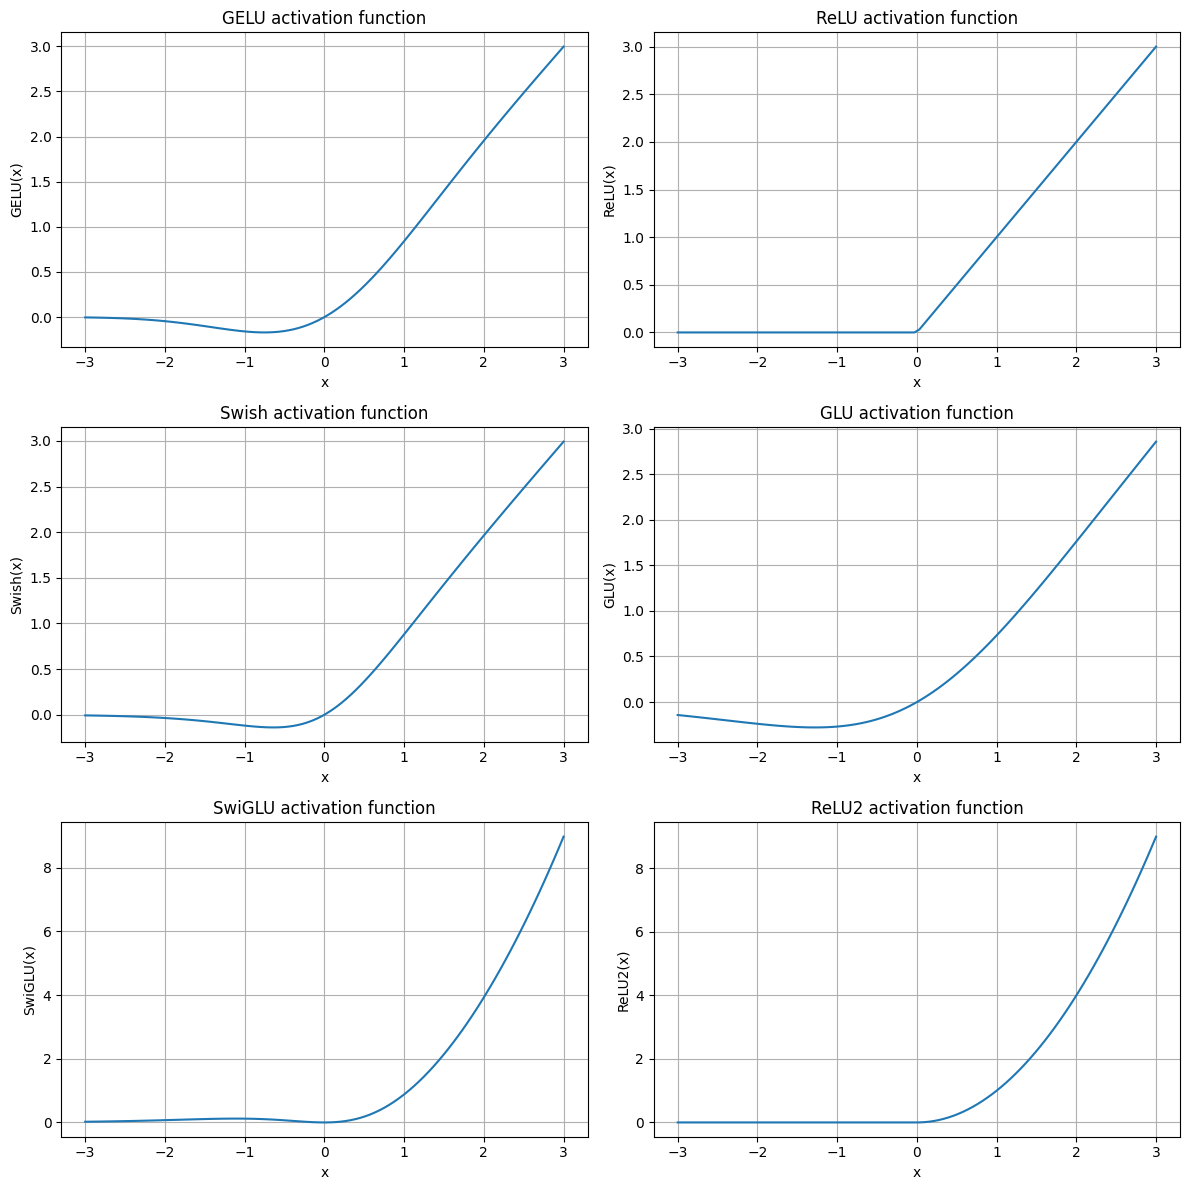

In [ ]:
activation_functions = {
    "GELU": GELU(),
    "ReLU": nn.ReLU(),
    "Swish": Swish(beta=2),
    "GLU": GLU(W=1, V=1, b=0, c=0),
    "SwiGLU": SwiGLU(W=1, V=1, b=0, c=0, beta=2),
    "ReLU2": ReLU2()
}


x = torch.linspace(-3, 3, 100)

plt.figure(figsize=(12, 12))

for i, (name, activation) in enumerate(activation_functions.items()):
  y = activation(x)

  plt.subplot(3, 2, i + 1)
  plt.plot(x, y)
  plt.title(f"{name} activation function")
  plt.xlabel("x")
  plt.ylabel(f"{name}(x)")
  plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# a feed forward neural network module
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


## Adding shortcut connections

In [ ]:
# a neural network to illustrate shortcut connections
class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
                      GELU()),
        nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
                      GELU()),
        nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
                      GELU()),
        nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
                      GELU()),
        nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
                      GELU())
    ])

  def forward(self, x):
    for layer in self.layers:
      layer_output = layer(x) # compute the output of the current layer
      if self.use_shortcut and x.shape == layer_output.shape: # check if shortcut can be applied
        x = x + layer_output
      else:
        x = layer_output
    return x

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut = False
)

In [ ]:
def print_gradients(model, x):
  output = model(x) # forward pas
  target = torch.tensor([[0.]])

  loss = nn.MSELoss()
  loss = loss(output, target) # calculate based on how close the target and output are

  loss.backward() # backward pass to calculate the gradients

  for name, param in model.named_parameters():
    if 'weight' in name:
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [ ]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [ ]:
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut = True
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694105327129364
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258540630340576


## Connecting attention and linear layers in a transformer block

In [ ]:
# the transformer block component of GPT
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in=cfg["emb_dim"],
        d_out=cfg["emb_dim"],
        context_length =cfg["context_length"],
        num_heads=cfg["n_heads"],
        qkv_bias=cfg["qkv_bias"],
        dropout=cfg["drop_rate"]
    )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):

        # shortcut connection for attention block
        shortcut = x
        x = self.norm1(x) # pre-layer norm > post-layer norm
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # add the original input back

        # shortcut connection for feedforward block
        shortcut = x
        x = self.norm2(x) # pre-layer norm
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # adds the original input back
        return x

In [ ]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## Coding the GPT model

In [ ]:
# the GPT model architecture implementation
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg)
        for _ in range (cfg["n_layers"])]
    )

    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False
    ) # weight tying: re-used weights from the tok_emb layer

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)

    pos_embeds = self.pos_emb(
        torch.arange(seq_len, device=in_idx.device)
    )
    x = tok_embeds + pos_embeds
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch: \n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch: 
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1819,  0.1556, -0.3976,  ..., -0.1606,  0.3322, -0.5951],
         [ 0.5878, -0.3884, -0.8200,  ..., -0.1671,  0.5164, -0.3482],
         [ 0.9747, -0.3029, -0.1256,  ...,  0.1998, -0.3979, -0.1978],
         [-0.8368,  0.0480, -0.3577,  ...,  1.0766,  0.2817, -0.6366]],

        [[ 0.0978,  0.3177, -0.3956,  ...,  0.4286,  0.0578, -0.6567],
         [ 0.0728, -0.1733, -0.1177,  ...,  0.6420, -0.0385,  0.1905],
         [ 0.8979,  1.0359, -0.1139,  ...,  0.7754,  0.2613,  0.2373],
         [ 0.1125,  0.2355,  0.3106,  ...,  1.0518, -0.3776, -0.1335]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 163009536


In [ ]:
# demonstration of weight tying
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [ ]:
total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
      f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,412,160


In [ ]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## Generating text

In [ ]:
# a function for the GPT model to generate text
def generate_text_simple(model, idx,
                         max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :]
    probs = torch.softmax(logits, dim=-1)
    idx_next = torch.argmax(probs, dim=-1, keepdim=True)
    idx = torch.cat((idx, idx_next), dim=1)
  return idx

In [ ]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:
model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [ ]:
decoded_text = tokenizer.decode(out[0].tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue
